In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 

In [3]:
df = pd.read_csv('earl694412-infinite-matchhistory1124.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            432 non-null    object 
 1   Player          432 non-null    object 
 2   MatchId         432 non-null    object 
 3   Map             432 non-null    object 
 4   Category        432 non-null    object 
 5   Playlist        432 non-null    object 
 6   Input           432 non-null    object 
 7   Queue           432 non-null    object 
 8   Csr             432 non-null    int64  
 9   Mmr             1 non-null      float64
 10  Outcome         432 non-null    object 
 11  Accuracy        432 non-null    float64
 12  DamageDone      432 non-null    int64  
 13  DamageTaken     432 non-null    int64  
 14  ShotsFired      432 non-null    int64  
 15  ShotsLanded     432 non-null    int64  
 16  ShotsMissed     432 non-null    int64  
 17  KD              432 non-null    flo

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df['DamageRatio'] = df['DamageDone'] / df['DamageTaken']
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']
df['LifetimeKD'] = df['Kills'].cumsum() / df['Deaths'].cumsum()
df['LifetimeDmgRatio'] = df['DamageDone'].cumsum() / df['DamageTaken'].cumsum()
df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'Csr'],axis=1)
dfR = df[df['Playlist'] == 'Ranked Arena']
dfr = dfR[dfR['Date']> '2023-01-01']
dfr = dfr[dfr['Outcome'] != 'Draw']
dfr = dfr[dfr['Outcome'] != 'Left']
dfr['Outcome'] = dfr['Outcome'].map({'Win': 1, 'Loss': 0})
dfr = dfr.drop('Playlist', axis=1)
dfr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 140 to 431
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              243 non-null    datetime64[ns]
 1   Map               243 non-null    object        
 2   Category          243 non-null    object        
 3   Outcome           243 non-null    int64         
 4   Accuracy          243 non-null    float64       
 5   DamageDone        243 non-null    int64         
 6   DamageTaken       243 non-null    int64         
 7   ShotsFired        243 non-null    int64         
 8   ShotsLanded       243 non-null    int64         
 9   ShotsMissed       243 non-null    int64         
 10  KD                243 non-null    float64       
 11  KDA               243 non-null    float64       
 12  Kills             243 non-null    int64         
 13  Deaths            243 non-null    int64         
 14  Assists           243 no

In [5]:
dfr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Outcome,243.0,0.497942,0.501028,0.000000,0.000000,0.000000,1.000000,1.000000
Accuracy,243.0,51.264897,5.551154,25.000000,48.150000,51.490000,54.260000,80.560000
DamageDone,243.0,4997.390947,1782.661665,480.000000,3752.500000,4669.000000,6183.000000,11536.000000
DamageTaken,243.0,4248.399177,1450.787094,807.000000,3325.500000,4028.000000,5106.500000,9962.000000
ShotsFired,243.0,228.979424,78.220469,16.000000,179.000000,219.000000,284.500000,464.000000
ShotsLanded,243.0,117.119342,40.986066,4.000000,92.000000,110.000000,145.000000,281.000000
ShotsMissed,243.0,111.860082,40.431313,7.000000,84.500000,107.000000,139.000000,261.000000
KD,243.0,1.268272,0.657483,0.310000,0.890000,1.180000,1.460000,6.000000
KDA,243.0,4.656461,5.660927,-7.000000,0.830000,4.660000,7.660000,31.000000
Kills,243.0,14.172840,6.469490,1.000000,10.000000,13.000000,18.000000,40.000000


In [6]:
dfr.tail()

,Date,Map,Category,Outcome,Accuracy,DamageDone,DamageTaken,ShotsFired,ShotsLanded,ShotsMissed,...,Score,Perfects,Medals,LengthSeconds,LengthMinutes,DamageRatio,ExcessKills,ExcessDeaths,LifetimeKD,LifetimeDmgRatio
427,2023-11-24 04:17:19,Solitude,Strongholds,0,54.64,6804,7203,291,159,132,...,3100,0,6,856,14.266667,0.944606,-1.0,-3.0,1.125485,1.158160
428,2023-11-24 04:32:57,Recharge,Extraction,0,46.71,5775,4649,319,149,170,...,2860,0,8,724,12.066667,1.242203,-1.0,4.0,1.125561,1.158396
429,2023-11-24 04:46:04,Aquarius,CTF 5 Captures,1,53.23,5538,5201,248,132,116,...,2275,0,3,752,12.533333,1.064795,2.0,0.0,1.125762,1.158103
430,2023-11-24 05:00:01,Solitude,Strongholds,0,52.82,6425,6300,301,159,142,...,3175,0,6,815,13.583333,1.019841,6.0,0.0,1.126290,1.157580
431,2023-11-24 05:15:13,Live Fire,Strongholds,1,53.66,8034,5929,328,176,152,...,3375,0,13,781,13.016667,1.355035,5.0,6.0,1.128837,1.158280


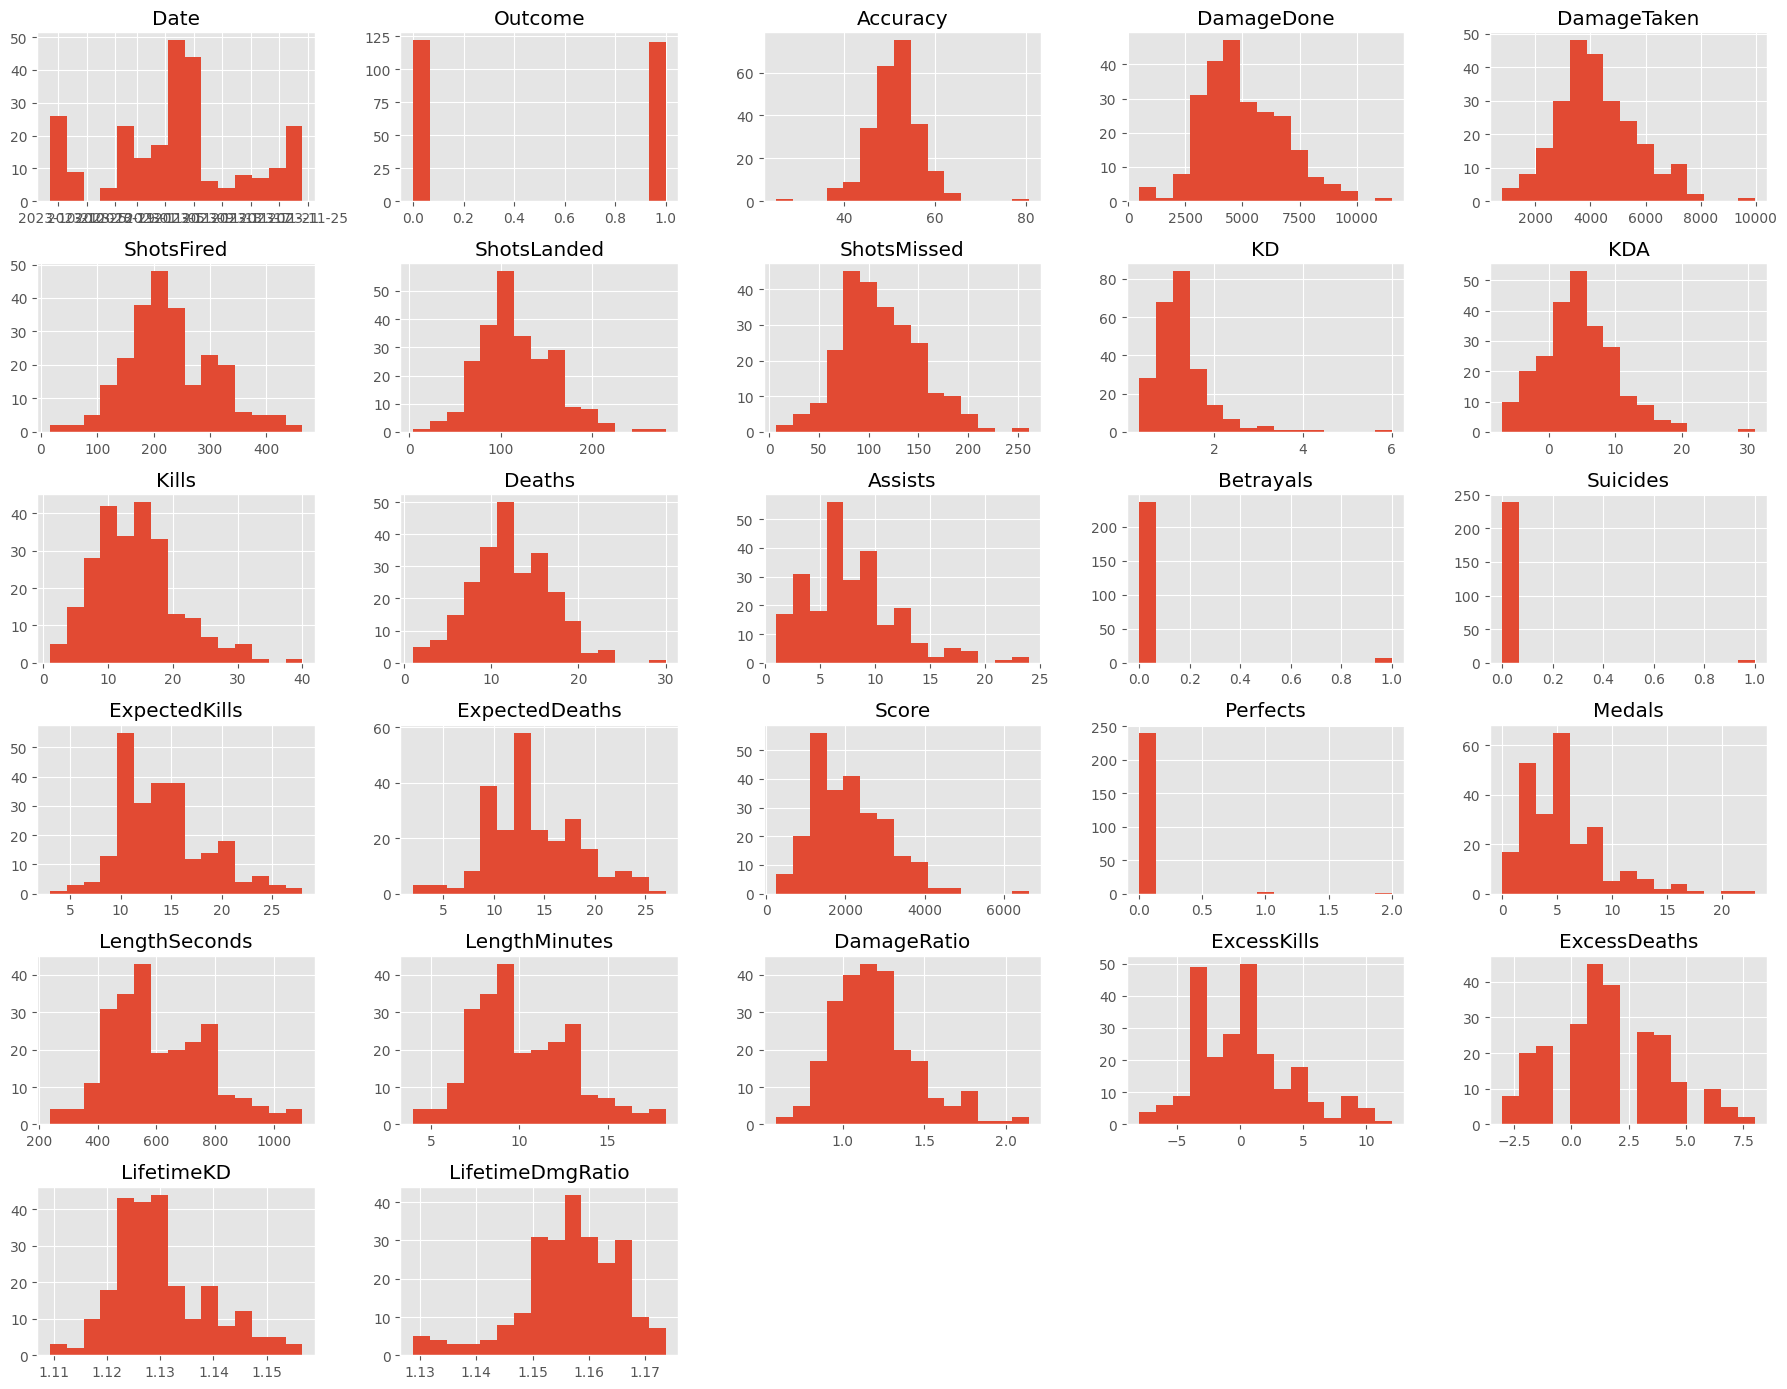

In [7]:
dfr.hist(bins=15, figsize=(18, 14))
plt.tight_layout()
plt.show()

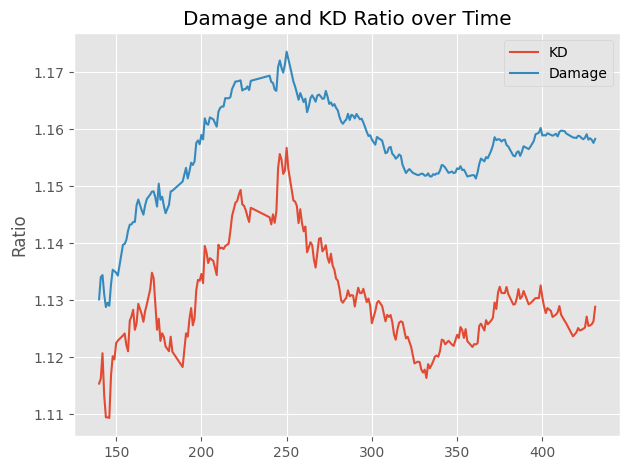

In [8]:
plt.plot(dfr['LifetimeKD'], label='KD' )
plt.plot(dfr['LifetimeDmgRatio'], label='Damage')
plt.title('Damage and KD Ratio over Time')
plt.ylabel('Ratio')
plt.legend()
plt.tight_layout()
plt.show()

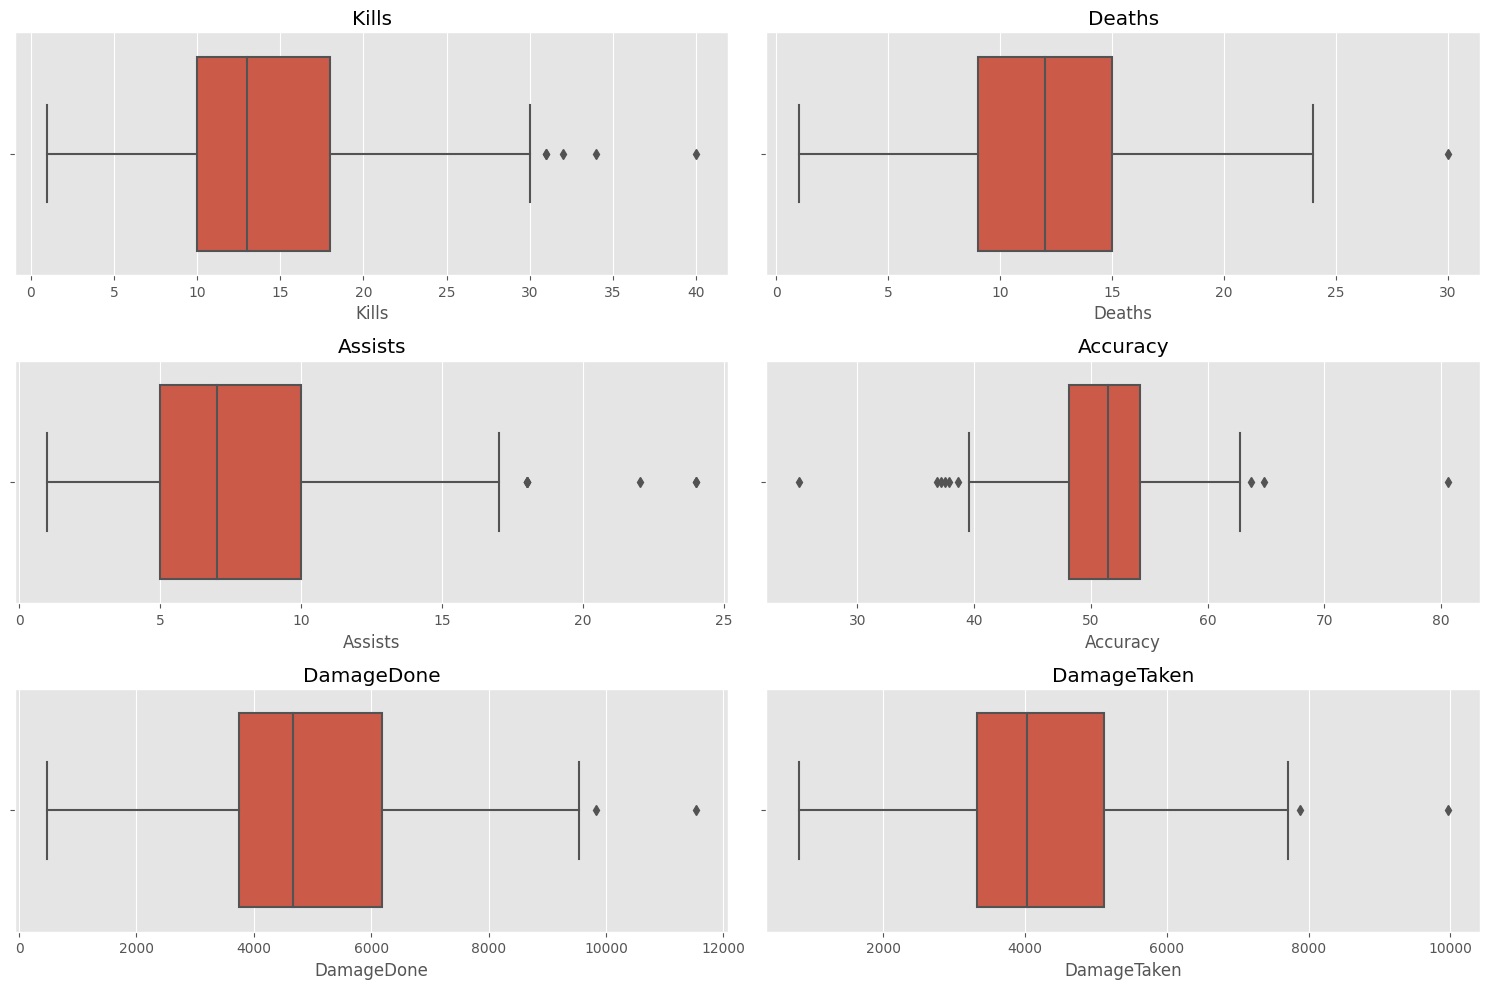

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
columns = ['Kills', 'Deaths', 'Assists', 'Accuracy', 'DamageDone', 'DamageTaken']

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot each column in a separate boxplot
for i, column in enumerate(columns):
    sns.boxplot(x=dfr[column], ax=axes[i])
    axes[i].set_title(column)

# Adjust layout
plt.tight_layout()
plt.savefig('Boxplots.png', dpi=500)
plt.show()


In [10]:
over = 5

dfover = dfr.loc[dfr['Deaths'] < over, 
                ['Kills', 'Deaths', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome']
                ].sort_values('DamageDone', ascending=False)

# print(dfover.head())
print(f'Overall KD: {round(dfover["Kills"].sum() / dfover["Deaths"].sum(),2)}')
print(f"Damage Ratio: {round(dfover['DamageDone'].sum() / dfover['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfover['Outcome']==1).sum()}-{(dfover['Outcome']==0).sum()}")

Overall KD: 2.5
Damage Ratio: 1.5
Win-Loss: 12-0


In [11]:
dfw = dfr.loc[dfr['Outcome'] == 1, 
                ['Kills', 'Deaths', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome']
                ].sort_values('Kills', ascending=False)

dfl = dfr.loc[dfr['Outcome'] == 0, 
                ['Kills', 'Deaths', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome']
                ].sort_values('Kills', ascending=False)

print('Wins')
print(f'Overall KD: {round(dfw["Kills"].sum() / dfw["Deaths"].sum(),2)}')
print(f"Average Kills: {round(dfw['Kills'].mean(),2)}")
print(f"Average Deaths: {round(dfw['Deaths'].mean(),2)}")
print(f"Average Damage Done: {round(dfw['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfw['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfw['DamageDone'].sum() / dfw['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfw['Outcome']==1).sum()}-{(dfw['Outcome']==0).sum()}")
print('\n')
print('Losses')
print(f'Overall KD: {round(dfl["Kills"].sum() / dfl["Deaths"].sum(),2)}')
print(f"Average Kills: {round(dfl['Kills'].mean(),2)}")
print(f"Average Deaths: {round(dfl['Deaths'].mean(),2)}")
print(f"Average Damage Done: {round(dfl['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfl['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfl['DamageDone'].sum() / dfl['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfl['Outcome']==1).sum()}-{(dfl['Outcome']==0).sum()}")

Wins
Overall KD: 1.33
Average Kills: 13.74
Average Deaths: 10.36
Average Damage Done: 4785
Average Damage Taken: 3865
Damage Ratio: 1.24
Win-Loss: 121-0


Losses
Overall KD: 1.05
Average Kills: 14.61
Average Deaths: 13.94
Average Damage Done: 5208
Average Damage Taken: 4629
Damage Ratio: 1.13
Win-Loss: 0-122


In [12]:
mapCatKD = dfr.pivot_table(index=['Map', 'Category'], 
                        values=['Kills', 'Deaths', 'Accuracy', 'KD', 'DamageRatio', 'Outcome'], 
                        aggfunc='mean')

desired_col_order = ['Kills', 'Deaths', 'KD', 'Accuracy', 'DamageRatio', 'Outcome']

# Reindex the pivot table with the desired column order
mapCatKD = mapKD.reindex(desired_col_order, axis=1)
mapKD = mapKD.round(2)

mapCatKD

NameError: name 'mapKD' is not defined

In [ ]:
mapKD = dfr.pivot_table(index='Map', 
                        values=['Kills', 'Deaths', 'Accuracy', 'KD', 'DamageRatio', 'Outcome'], 
                        aggfunc='mean')

desired_col_order = ['Kills', 'Deaths', 'KD', 'Accuracy', 'DamageRatio', 'Outcome']

# Reindex the pivot table with the desired column order
mapKD = mapKD.reindex(desired_col_order, axis=1)
mapKD = mapKD.round(2)

mapKD

,Kills,Deaths,KD,Accuracy,DamageRatio,Outcome
Map,,,,,,
Aquarius,15.00,11.65,1.37,51.51,1.27,0.52
Argyle,12.50,11.30,1.12,48.78,1.21,0.30
Empyrean,13.33,12.22,1.10,49.73,1.17,0.33
Forbidden,13.00,9.12,1.57,52.73,1.41,0.62
Live Fire,12.66,12.04,1.22,51.72,1.12,0.51
Recharge,15.28,13.00,1.26,49.90,1.20,0.53
Solitude,15.09,12.71,1.26,51.21,1.19,0.42
Streets,14.05,11.90,1.28,52.81,1.21,0.57


In [ ]:
catKD = dfr.pivot_table(index='Category', 
                        values=['Kills', 'Deaths', 'Accuracy', 'KD', 'DamageRatio', 'Outcome'], 
                        aggfunc='mean')

desired_col_order = ['Kills', 'Deaths', 'KD', 'Accuracy', 'DamageRatio', 'Outcome']

# Reindex the pivot table with the desired column order
catKD = catKD.reindex(desired_col_order, axis=1)
catKD = catKD.round(2)

catKD

,Kills,Deaths,KD,Accuracy,DamageRatio,Outcome
Category,,,,,,
CTF 3 Captures,12.93,10.96,1.25,50.27,1.26,0.41
CTF 5 Captures,21.00,16.00,1.39,51.32,1.28,0.25
Extraction,13.37,10.74,1.42,53.68,1.26,0.49
King of the Hill,16.50,13.81,1.28,52.53,1.15,0.59
Oddball,16.32,15.13,1.14,51.10,1.18,0.48
Slayer,10.30,9.59,1.24,49.87,1.15,0.59
Strongholds,17.03,13.97,1.25,51.33,1.20,0.41
